In [93]:
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy.spatial import distance_matrix

number_cities = 10

'''
Generate city names in alphabetical order
'''
cities = []

for i in range(number_cities):
    city = chr(ord('A') + i)
    cities.append(city)


depot_longitude       =  -79.383292
depot_latitude        =  43.652224

demands = np.random.randint(1, 11, number_cities-1)
demands = np.insert(demands,0,0)
print(demands)

longitude = np.random.normal(depot_longitude, 0.008, number_cities)
latitude  = np.random.normal(depot_latitude, 0.008, number_cities)

coords  =  []
k       =  0
for citie in range(len(cities)):
    coords.append([abs(round(longitude[k]*100000)), abs(round(latitude[k]*100000))])
    k += 1

print(coords)
df      = pd.DataFrame(coords, columns=['xcord', 'ycord'],    index=cities)
#df     = pd.DataFrame({"longitude":longitude,
#                       "latitude":latitude},  index=cities)

df_map = pd.DataFrame({"longitude":longitude,
                       "latitude":latitude,
                       "demand":demands},  index=cities)
print(df)
print("-------------------------------")
print(df_map)

[0 6 9 5 8 4 1 1 1 5]
[[7938410, 4365636], [7938869, 4365051], [7937140, 4365041], [7937745, 4364397], [7938683, 4365699], [7936750, 4365131], [7939693, 4364770], [7938157, 4365006], [7938370, 4364428], [7938049, 4365924]]
     xcord    ycord
A  7938410  4365636
B  7938869  4365051
C  7937140  4365041
D  7937745  4364397
E  7938683  4365699
F  7936750  4365131
G  7939693  4364770
H  7938157  4365006
I  7938370  4364428
J  7938049  4365924
-------------------------------
   longitude   latitude  demand
A -79.384099  43.656362       0
B -79.388690  43.650505       6
C -79.371396  43.650411       9
D -79.377446  43.643972       5
E -79.386826  43.656992       8
F -79.367499  43.651314       4
G -79.396932  43.647699       1
H -79.381573  43.650064       1
I -79.383696  43.644281       1
J -79.380491  43.659244       5


In [94]:
x, y = coords.T                                   # We define that the first value of coords is X and the second is Y
plt.plot(x[0], y[0], c='r', marker='s')
plt.scatter(x[1:],y[1:], c='b')             # Put the x and y axis in pyplot
plt.show()                                  # Display the coordinates of the cities on an orthonormal coordinate system

AttributeError: 'list' object has no attribute 'T'

In [95]:
'''
Creation of the matrix of distances between cities
'''

matrix   = distance_matrix(df.values, df.values)
distance = pd.DataFrame(matrix, index=df.index, columns=df.index)
print(matrix)
print("--------------------------")
print(distance)

[[   0.          743.57649237 1402.47103357 1406.18135388  280.17494535
  1735.11526995 1547.91634141  678.90279127 1208.66207022  461.80623642]
 [ 743.57649237    0.         1729.02891821 1300.41993218  674.16615163
  2120.50960856  870.59577302  713.42063329  798.20423452 1197.71824734]
 [1402.47103357 1729.02891821    0.          883.60681301 1677.44239841
   400.24992192 2567.34298449 1017.60208333 1374.28854321 1267.26871657]
 [1406.18135388 1300.41993218  883.60681301    0.         1604.69560977
  1236.43883795 1983.38927092  735.27205849  625.76832774 1556.96660208]
 [ 280.17494535  674.16615163 1677.44239841 1604.69560977    0.
  2014.72405058 1372.27584691  870.0143677  1308.97287978  672.74140649]
 [1735.11526995 2120.50960856  400.24992192 1236.43883795 2014.72405058
     0.         2965.05817818 1412.5416808  1765.95838003 1521.92312552]
 [1547.91634141  870.59577302 2567.34298449 1983.38927092 1372.27584691
  2965.05817818    0.         1554.02445283 1366.48929743 2008.594

In [96]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from time import time


class VPR:

    def __init__(self, n_trucks, dimension, capacity, demands, adj_matrix):
        self.n_trucks             =   n_trucks
        self.dimension            =   dimension
        self.capacity             =   capacity
        self.demands              =   demands
        self.adj_matrix           =   adj_matrix
        self.adj_matrix_sum       =   adj_matrix.sum()
        self.final_cost           =   self.adj_matrix_sum
        self.final_sol            =   None

        self.epochs               =   None
        self.n_ants               =   None
        self.alpha                =   None
        self.beta                 =   None
        self.rho                  =   None
        self.init_pheromone_value =   None
        self.pheromone_map        =   None
        self.raw_prob_matrix      =   None
        self.tabu                 =   None
        self.tabu_sum             =   None
        self.capacity_left        =   None

    def get_probality(self, raw_prob_list):
        prob_list = raw_prob_list/raw_prob_list.sum()
        return prob_list

    def get_next_vertex(self, pos):
        potential      =  deepcopy(self.tabu)
        potential_sum  =  self.tabu_sum
        while potential_sum < self.dimension:
            raw_prob_list  =  deepcopy(self.raw_prob_matrix[pos]) * potential
            next_vertex    =  np.random.choice(np.arange(0, self.dimension), p=self.get_probality(raw_prob_list))
            if self.demands[next_vertex] <= self.capacity_left:
                return next_vertex
            potential[next_vertex]  =  0
            potential_sum          +=  1
        return 0

    def local_update(self, i, j):
        self.pheromone_map[i, j]  += self.rho * self.init_pheromone_value / self.adj_matrix[i, j]
        self.pheromone_map[j, i]   = self.pheromone_map[i, j]
        self.raw_prob_matrix[i, j] = self.raw_prob_matrix[j, i] = (self.pheromone_map[i, j] ** self.alpha) * \
                                                                  ((1 / self.adj_matrix[i, j]) ** self.beta)

    def global_update(self, best_solution, best_cost):
        for one_path in best_solution:
            for i in range(len(one_path)-1):
                self.pheromone_map[one_path[i], one_path[i + 1]]    += self.rho * self.capacity / best_cost
                self.pheromone_map[one_path[i + 1], one_path[i]]    =  self.pheromone_map[one_path[i], one_path[i + 1]]
                self.raw_prob_matrix[one_path[i], one_path[i + 1]]  =  \
                    self.raw_prob_matrix[one_path[i + 1], one_path[i]] = \
                    (self.pheromone_map[one_path[i], one_path[i + 1]] ** self.alpha) * \
                    ((1 / self.adj_matrix[one_path[i], one_path[i + 1]]) ** self.beta)

    def get_cost(self, solution):
        current_cost = 0
        for i in range(len(solution) - 1):
            current_cost += self.adj_matrix[solution[i], solution[i + 1]]
        return current_cost

    def plot_function(self):
        box = {'facecolor': 'white',
               'edgecolor': 'black',
               'boxstyle': 'round'}
        plt.figure(figsize=(9.5, 6))
        plt.text(self.epochs - 18, self.show_epoch[4] - 60,
                 f'cost={round(self.final_cost, 2)}, \n'
                 f'epochs={self.epochs}, \n'
                 f'n_ants={self.n_ants}, \n'
                 f'alpha={self.alpha}, \n'
                 f'beta={self.beta}, \n'
                 f'p={self.rho}, \n'
                 f'init_ph={self.init_pheromone_value}',
                 bbox=box, color='black', fontsize=12)
        plt.plot(np.arange(self.epochs), self.show_cost, 'r')
        plt.plot(np.arange(self.epochs), self.show_epoch, 'k')
        plt.grid()
        plt.title(f'Fitness function for A-n{self.dimension}-k{self.n_trucks}', fontsize=18)
        plt.xlabel('epoch')
        plt.ylabel('cost')
        plt.show()

    def compute(self, epochs=100, n_ants=50, alpha=1.5, beta=0.3, rho=0.95, init_pheromone=1000):
        self.epochs                =  epochs
        self.n_ants                =  n_ants
        self.alpha                 =  alpha
        self.beta                  =  beta
        self.rho                   =  rho
        self.init_pheromone_value  =  init_pheromone
        self.pheromone_map         =  np.full(shape=(self.dimension, self.dimension), fill_value=self.init_pheromone_value)
        np.fill_diagonal(self.pheromone_map, 0)

        np.fill_diagonal(self.adj_matrix, 0.1)
        self.raw_prob_matrix = (self.pheromone_map ** self.alpha) * ((1 / self.adj_matrix) ** self.beta)
        np.fill_diagonal(self.adj_matrix, 0)

        self.show_epoch  =  []
        self.show_cost   =  []
        for epoch in range(self.epochs):
            time_s         = time()
            best_solution  = None
            best_cost      = self.adj_matrix_sum
            for ant in range(self.n_ants):
                current_state       =  0
                solutions           =  []
                one_path_solution   =  [0]
                self.capacity_left  =  self.capacity
                self.tabu           =  np.ones(self.dimension)
                self.tabu[0]        =  0
                self.tabu_sum       =  1
                while self.tabu_sum < self.dimension:
                    next_state = self.get_next_vertex(current_state)
                    if next_state == 0:
                        one_path_solution.append(0)
                        solutions.append(one_path_solution)
                        one_path_solution   =  [0]
                        current_state       =  0
                        self.capacity_left  =  self.capacity
                        continue
                    one_path_solution.append(next_state)
                    self.capacity_left -= self.demands[next_state]
                    self.local_update(current_state, next_state)
                    current_state             =  next_state
                    self.tabu[current_state]  =  0
                    self.tabu_sum            +=  1

                one_path_solution.append(0)
                solutions.append(one_path_solution)
                cost = sum([self.get_cost(sol) for sol in solutions])

                assert all(np.unique(np.hstack(solutions)) == np.arange(self.dimension))

                if cost < best_cost:
                    best_cost      =  cost
                    best_solution  =  solutions

            self.global_update(best_solution, best_cost)
            self.show_epoch.append(best_cost)
            if self.final_cost > best_cost:
                self.final_cost  =  best_cost
                self.final_sol   =  best_solution
                self.show_cost.append(self.final_cost)
            else:
                self.show_cost.append(self.show_cost[-1])
            # print(f'Epoch: {epoch} | time: {round(time() - time_s, 4)}| best cost: {best_cost}')

        self.final_sol = [(np.array(x) + 1).tolist() for x in self.final_sol]

In [97]:
car_number                       =  1
distance_ant                     =  matrix
distance_ant[distance_ant == 0]  =  np.inf

capacity                         =  30
dimension                        =  number_cities

adj_matrix                       =  matrix

case = VPR(car_number, dimension, capacity, demands, adj_matrix)
case.compute(epochs=300, n_ants=100, alpha=1, beta=1, rho=0.95, init_pheromone=1000)

print(f'Found solution:')
test534 = case.final_sol
display(case.final_sol)

Found solution:


[[1, 2, 7, 5, 1], [1, 10, 6, 3, 1], [1, 9, 4, 8, 1]]

In [77]:
plt.scatter(x[0], y[0], c='r', marker='s')
plt.scatter(x[1:], y[1:])
col = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
i   = 0
  
for truck in test534:
    for test in range(len(truck)-1):
        dot1 = truck[test]-1
        dot2 = truck[test+1]-1
        print("Couple : ", dot1, dot2)
        plt.plot([x[dot1], x[dot2]], [y[dot1], y[dot2]], c=col[(i) % len(col)])
    i += 1
    print("---------------------")
plt.show

Couple :  0 7
Couple :  7 3
Couple :  3 8


IndexError: string index out of range

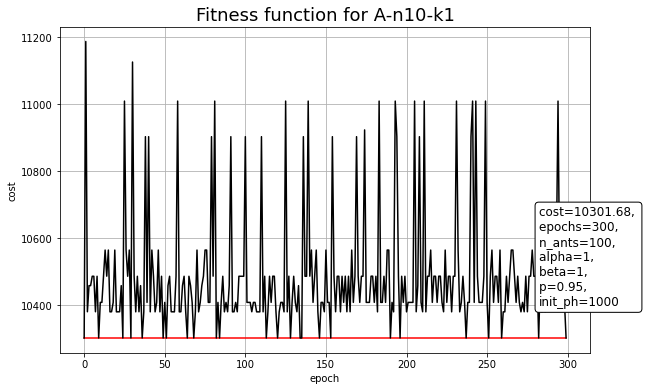

In [98]:
case.plot_function()

In [84]:
#import folium
#
##m = folium.Map(location=[43.652597, -79.384669], tiles="CartoDB positron", zoom_start=13)
#
#
#depot_longitude       =  -79.383292
#depot_latitude        =  43.652224
#customer_count        =  10
#
##coords_long_lat       = np.random.randint(low=[latitude_min, latitude_max], high=[longitude_max, latitude_max], size=(number_cities, 2))
#
#demand = np.random.randint(1, 11, customer_count-1)
#demand = np.insert(demand,0,0)
#print(demand)
#
#df_map = pd.DataFrame({"longitude":np.random.normal(depot_longitude, 0.008, customer_count),
#                       "latitude":np.random.normal(depot_latitude, 0.008, customer_count),
#                       "demand":demand})
#
#
#print(df_map)

In [101]:
import folium
m = folium.Map(location=[43.652597, -79.384669], tiles="CartoDB positron", zoom_start=13)
m
for index, row in df_map.iterrows():
    icon_house = "circle"
    color      = "blue"
    if index == "A":
        icon_house = "home"
        color      = "red"
    popup_demand = "Demand: " + str(row['demand'])
    folium.Marker(location=[row['latitude'], row['longitude']], tooltip="click for more", popup = popup_demand, icon=folium.Icon(color=color ,icon=icon_house, prefix='fa')).add_to(m)
m

In [103]:
col = ['blue', 'green', 'red', 'pink', 'orange', 'yellow', 'black', 'brown']
i   = 0


for truck in test534:
    for test in range(len(truck)-1):
        dot1 = truck[test]-1
        dot2 = truck[test+1]-1
        dot1_loc = df_map.iloc[dot1]
        dot2_loc = df_map.iloc[dot2]
        

        line = [(dot1_loc['latitude'],dot1_loc['longitude']), (dot2_loc['latitude'],dot2_loc['longitude'])]
        
        folium.PolyLine(line,
                color=col[(i) % len(col)],
                weight=15,
                opacity=0.8).add_to(m)
    i += 1

m